# Project

## Build Model to Predict Whether Loans Will Be Charged Off

### Import Libraries

In [1]:
#import libraries

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
import time
import random

Using TensorFlow backend.


In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 1000
random_seed=42

In [3]:
%%time
filename = "loan.csv"
df_full = pd.read_csv(filename)
df_full.shape

CPU times: user 43.4 s, sys: 16.9 s, total: 1min
Wall time: 1min 3s


(2260668, 145)

In [4]:
%%time
#load sample of csv
#data set is very large (> 2 million), so load 100,000 rows to build model to save computational power
#load sample of csv
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 100000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df = pd.read_csv(filename, skiprows=skip)



CPU times: user 13.7 s, sys: 1.12 s, total: 14.8 s
Wall time: 15.4 s


In [5]:
#reorder columns alphabetically 
df = df.reindex(sorted(df.columns), axis=1)

#display 10 random rows from dataframe
df.sample(10, random_state=random_seed)

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,debt_settlement_flag_date,deferral_term,delinq_2yrs,delinq_amnt,desc,disbursement_method,dti,dti_joint,earliest_cr_line,emp_length,emp_title,funded_amnt,funded_amnt_inv,grade,hardship_amount,hardship_dpd,hardship_end_date,hardship_flag,hardship_last_payment_amount,hardship_length,hardship_loan_status,hardship_payoff_balance_amount,hardship_reason,hardship_start_date,hardship_status,hardship_type,home_ownership,id,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,max_bal_bc,member_id,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,next_pymnt_d,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,orig_projected_additional_accrued_interest,out_prncp,out_prncp_inv,payment_plan_start_date,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_bal_joint,revol_util,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,settlement_amount,settlement_date,settlement_percentage,settlement_status,settlement_term,sub_grade,tax_liens,term,title,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
75721,0.0,1.0,FL,NaN,80000.0,NaN,Individual,26027.0,14899.0,42.9,0.0,0.0,0.0,N,NaN,NaN,0.0,0.0,NaN,Cash,11.34,NaN,Oct-1999,10+ years,NaN,15000,14975.0,B,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MORTGAGE,NaN,NaN,f,NaN,NaN,1.0,333.60,11.99,Oct-2013,Nov-2017,3794.05,Dec-2017,15000,Fully Paid,NaN,NaN,120.0,170.0,26.0,6.0,3.0,69.0,NaN,NaN,NaN,26.0,NaN,2.0,NaN,NaN,0.0,6.0,8.0,6.0,12.0,7.0,8.0,15.0,8.0,10.0,0.0,0.0,0.0,1.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,96.0,16.7,1,0.0,0.0,credit_card,n,0.00,13498,NaN,35.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B3,0.0,60 months,Pay off cc,0.0,260267.0,296563.0,25.0,23870.0,NaN,26100.0,NaN,21463.0,19806.848196,19773.84,4806.85,0.0,15000.00,37600.0,NaN,Verified,NaN,342xx
80184,0.0,6.0,CA,NaN,65000.0,NaN,Individual,8046.0,4819.0,75.0,0.0,0.0,0.0,N,NaN,NaN,0.0,0.0,Borrower added on 11/26/12 > This loan will ...,Cash,34.23,NaN,Jun-2002,10+ years,Usmc,25000,24925.0,E,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RENT,NaN,NaN,f,NaN,NaN,1.0,669.19,20.49,Dec-2012,Nov-2018,15.18,Jan-2018,25000,Fully Paid,NaN,NaN,116.0,127.0,2.0,2.0,0.0,57.0,NaN,NaN,NaN,2.0,57.0,4.0,57.0,NaN,0.0,4.0,5.0,6.0,11.0,12.0,8.0,17.0,5.0,12.0,0.0,0.0,0.0,4.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,93.0,40.0,1,0.0,0.0,debt_consolidation,n,0.00,14777,NaN,41.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E1,0.0,60 months,Credit card debt consolidation,0.0,72412.0,94759.0,30.0,72412.0,NaN,19300.0,NaN,59359.0,40149.843551,40029.39,15149.84,0.0,25000.00,35400.0,NaN,Verified,NaN,920xx
19864,0.0,6.0,NY,57.0,55412.0,NaN,Individual,2598.0,464.0,96.0,0.0,0.0,0.0,N,NaN,NaN,0.0,0.0,NaN,Cash,31.03,NaN,Aug-2005,NaN,NaN,5000,5000

In [6]:
df.shape

(100000, 145)

## Data Preparation

In [7]:
#many columns have multiple null values
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 145 columns):
acc_now_delinq                                99999 non-null float64
acc_open_past_24mths                          97772 non-null float64
addr_state                                    100000 non-null object
all_util                                      61620 non-null float64
annual_inc                                    99999 non-null float64
annual_inc_joint                              5342 non-null float64
application_type                              100000 non-null object
avg_cur_bal                                   96845 non-null float64
bc_open_to_buy                                96728 non-null float64
bc_util                                       96678 non-null float64
chargeoff_within_12_mths                      99995 non-null float64
collection_recovery_fee                       100000 non-null float64
collections_12_mths_ex_med                    99995 non-null 

In [8]:
#3 columns are 100% null, these should be dropped
df.isnull().all().value_counts()

False    142
True       3
dtype: int64

In [9]:
#drop 100% null columns
null_columns=df.columns[df.isnull().all()]
df[null_columns].isnull().sum()
empty_cols = null_columns.tolist()
for col in empty_cols:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)
print("The following empty columns have been dropped: " + "\n \n" + str(empty_cols))

The following empty columns have been dropped: 
 
['id', 'member_id', 'url']


In [10]:
#drop text columns
#is it possible that some useful data could be scraped from these text columns, but that is out of the scope of a short project
text_cols = ['desc','emp_title','title']
for col in text_cols:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)
print("The following columns have been dropped: " + "\n \n" + str(text_cols))



The following columns have been dropped: 
 
['desc', 'emp_title', 'title']


In [11]:
#percentage of null columns in remaining columns
df.isnull().sum() / df.shape[0] * 100.00

acc_now_delinq                                 0.001
acc_open_past_24mths                           2.228
addr_state                                     0.000
all_util                                      38.380
annual_inc                                     0.001
annual_inc_joint                              94.658
application_type                               0.000
avg_cur_bal                                    3.155
bc_open_to_buy                                 3.272
bc_util                                        3.322
chargeoff_within_12_mths                       0.005
collection_recovery_fee                        0.000
collections_12_mths_ex_med                     0.005
debt_settlement_flag                           0.000
debt_settlement_flag_date                     98.568
deferral_term                                 99.514
delinq_2yrs                                    0.001
delinq_amnt                                    0.001
disbursement_method                           

In [12]:
#replace multiple hardship columns with a single hardship flag

hardship_cols = [
'hardship_amount',                             
'hardship_dpd',                                 
'hardship_end_date',                           
'hardship_last_payment_amount',
'hardship_length',
'hardship_loan_status',
'hardship_payoff_balance_amount',
'hardship_reason',
'hardship_start_date',
'hardship_status',
'hardship_type']

for col in hardship_cols:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)
print("The following columns have been dropped: " + "\n \n" + str(hardship_cols))


#replace hardship flag Y/N with 1/0
df.hardship_flag.value_counts()
df.loc[df['hardship_flag'] == 'N', 'hardship_flag'] = 0
df.loc[df['hardship_flag'] == 'Y', 'hardship_flag'] = 1


The following columns have been dropped: 
 
['hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type']


 Annual Income can probably be merged with annual income joint, but first need to check that annual income joint is always greater than or equal to annual income

In [13]:
#can annual_inc and annual_inc_joint be merged?

df_inc = df.loc[df['annual_inc_joint'].notnull(), ['annual_inc','annual_inc_joint']]
df_inc['joint_greater_than'] = df_inc.annual_inc_joint > df_inc.annual_inc
df_inc['joint_greater_than_or_equal'] = df_inc.annual_inc_joint >= df_inc.annual_inc
print(df_inc.joint_greater_than.value_counts())
print(df_inc.joint_greater_than_or_equal.value_counts())

True     5298
False      44
Name: joint_greater_than, dtype: int64
True    5342
Name: joint_greater_than_or_equal, dtype: int64


In [14]:
#merge annual_inc and annual_inc_joint

df['annual_inc'] = df.apply(lambda row: row['annual_inc_joint'] if pd.notnull(row['annual_inc_joint']) else row['annual_inc'],axis=1)

In [16]:
#drop all other columns relating to 2nd application, just keep joint application 1 or 0
%time
sec_list = []
for col in df.columns:
    if 'sec_app' in col:
        sec_list.append(col)
    if 'joint' in col:
        sec_list.append(col)
for col in sec_list:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)
print("The following columns have been dropped: " + "\n \n" + str(sec_list))

df.application_type.value_counts()


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
The following columns have been dropped: 
 
[]


Individual    94658
Joint App      5342
Name: application_type, dtype: int64

In [17]:
df.loc[df['application_type'] == 'Individual','application_type'] = 0
df.loc[df['application_type'] == 'Joint App','application_type'] = 1
df.rename(columns={'application_type': 'joint_app'}, inplace=True)
df.joint_app.value_counts()

0    94658
1     5342
Name: joint_app, dtype: int64

In [18]:
#fill null income values with zipcode average
df = df.dropna(axis=0, subset=['zip_code'])


df['annual_inc'] = df.groupby("zip_code")['annual_inc'].transform(lambda x: x.fillna(x.mean()))

In [21]:
#drop columns with more than 2% null values
df = df.loc[:, df.isnull().mean() < .02]

In [22]:
df = df.dropna(how='any',axis=0) 

In [23]:
df.shape

(99686, 50)

In [24]:
#policy code does not add anything and addr_state info should be better provided by zip_code
df.drop(['addr_state','policy_code'], axis=1, inplace=True)

In [25]:
#some columns that should be numeric or datetimes are strings
%time
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'])
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'])
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])
df['term'] = pd.to_numeric(df['term'].str.replace(' months', ''))



CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [26]:
#convert datetime to ordinal so they can be processed by classifiers
date_list = ['last_credit_pull_d','issue_d','last_pymnt_d','earliest_cr_line_date']

for col in date_list:
    df[col] = df[col].apply(lambda x: x.toordinal())

#### Create target variable

target variable (loan_status) changed to 1 (charged off) or 0 (not charged off)

In [27]:

df.loan_status.value_counts()

Fully Paid                                             46117
Current                                                40578
Charged Off                                            11405
Late (31-120 days)                                       908
In Grace Period                                          419
Late (16-30 days)                                        162
Does not meet the credit policy. Status:Fully Paid        80
Does not meet the credit policy. Status:Charged Off       15
Default                                                    2
Name: loan_status, dtype: int64

In [28]:
#drop all that are not fully paid or charged off as those accounts are still active and may become fully paid or charged off in time. Including them would lead to data leakage

df.loc[(df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'),'loan_status'] = 'Charged Off'
df.loc[(df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'),'loan_status'] = 'Fully Paid'
df = df[(df['loan_status'] == "Fully Paid") | (df['loan_status'] == "Charged Off")]
df.loc[df['loan_status'] != 'Charged Off','loan_status'] = 0
df.loc[df['loan_status'] == 'Charged Off','loan_status'] = 1

In [29]:
df.loan_status.value_counts(normalize=True)

0    0.801795
1    0.198205
Name: loan_status, dtype: float64

In [30]:
#reset index after removing rows
df = df.reset_index(drop=True)
df.head()

,acc_now_delinq,annual_inc,joint_app,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,delinq_2yrs,delinq_amnt,disbursement_method,dti,earliest_cr_line,funded_amnt,funded_amnt_inv,grade,hardship_flag,home_ownership,initial_list_status,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,open_acc,out_prncp,out_prncp_inv,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_util,sub_grade,tax_liens,term,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,verification_status,zip_code,earliest_cr_line_date
0,0.0,50000.0,0,0.0,0.0,0.0,N,0.0,0.0,Cash,18.70,Oct-1993,10000,10000.0,A,0,OWN,w,0.0,314.25,8.19,737029,737060,10010.06,737060,10000,0,11.0,0.0,0.0,0.0,0.0,other,n,0.0,14260,40.2,A4,0.0,36,27.0,10003.235500,10003.24,3.24,0.0,10000.0,Source Verified,791xx,727837
1,0.0,75000.0,0,0.0,0.0,0.0,N,0.0,0.0,Cash,12.05,Aug-2008,12000,12000.0,D,0,RENT,w,0.0,451.43,20.89,737029,737091,12311.24,737060,12000,0,12.0,0.0,0.0,0.0,0.0,debt_consolidation,n,0.0,11027,26.1,D4,0.0,36,25.0,12276.418978,12276.42,276.42,0.0,12000.0,Source Verified,168xx,733255
2,0.0,73000.0,0,0.0,0.0,0.0,N,0.0,0.0,Cash,10.96,Jan-2002,10000,10000.0,C,0,MORTGAGE,f,0.0,235.13,14.47,737029,737029,10025.32,737060,10000,0,11.0,0.0,0.0,0.0,0.0,home_improvement,n,0.0,4819,23.3,C2,0.0,60,36.0,10009.242500,10009.24,9.24,0.0,10000.0,Source Verified,060xx,730851
3,0.0,39000.0,0,0.0,0.0,0.0,N,0.0,0.0,Cash,0.77,Sep-2006,8000,8000.0,A,0,MORTGAGE,w,0.0,247.09,7.02,737029,737060,8055.93,737060,8000,0,4.0,0.0,0.0,0.0,0.0,major_purchase,n,0.0,809,4.2,A2,0.0,36,12.0,8051.245661,8051.25,51.25,0.0,8000.0,Not Verified,321xx,732555
4,0.0,125000.0,1,0.0,0.0,0.0,N,0.0,0.0,Cash,1.90,Nov-2012,24000,24000.0,E,0,RENT,w,0.0,736.73,27.27,737029,737060,24707.72,737060,24000,0,3.0,0.0,0.0,0.0,0.0,debt_consolidation,n,0.0,1909,33.5,E5,0.0,60,3.0,24616.815608,24616.82,616.82,0.0,24000.0,Verified,902xx,734808


In [31]:
df['loan_status'] = df['loan_status'].astype(str).astype(int)

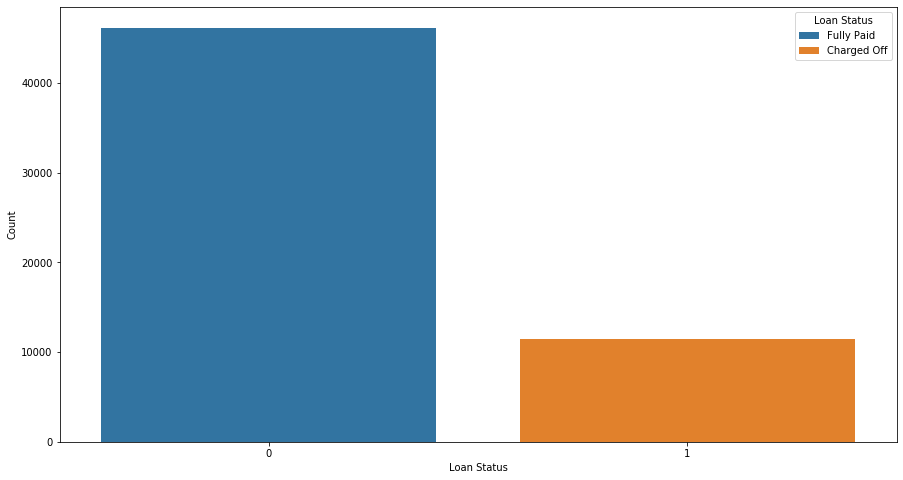

In [58]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='loan_status',data=df,hue='loan_status',dodge=False)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Count')
h,l = ax.get_legend_handles_labels()
labels=["Fully Paid", "Charged Off"]
ax.legend(h,labels,title="Loan Status", loc="upper right") 

plt.show;
